In [26]:
import math
import numpy as np
import pandas as pd
from mapie.classification import MapieClassifier
from mapie.metrics import classification_coverage_score, classification_mean_width_score
import matplotlib.pyplot as plt
import json

from src.model import MockModel
from src.utils import index_for_arange, write_results, cq_labels, cq_filter
import src.plot as plot
from src.eval import (
    adjusted_classification_x_width_score,
    size_stratified_classification_coverage_score,
    cq_stats,
    set_size_equals,
)
from src.heuristics import TopKSelector, HeuristicCutoffSelector, TopKCutoffSelector

In [27]:
# load data
dataset = 'acid'
intent_classifier = 'bert'
data_dir = f'data/{dataset}/{intent_classifier}/'

df_train_preds = pd.read_csv(data_dir + "train_predictions.csv")
df_test_preds = pd.read_csv(data_dir + "test_predictions.csv")
df_calibration_preds = pd.read_csv(data_dir + "calibration_predictions.csv")

labels = pd.read_csv(data_dir+'/labels.csv', header=0, names=['index','label'])
labels = list(labels.label)
N_INTENTS = len(labels)

In [28]:
# check train-calibration-test split sizes
df_train_preds.shape[0], df_calibration_preds.shape[0], df_test_preds.shape[0]

(13303, 4435, 4434)

In [29]:
# apply some basic transformations
df_train = df_train_preds.reset_index().rename(columns={'index': 'utterance'})
df_test = df_test_preds.reset_index().rename(columns={'index': 'utterance'})
df_calibration = df_calibration_preds.reset_index().rename(columns={'index': 'utterance'})

df_train['utterance'] = df_train['utterance'].apply(lambda h: 'train_' + str(h))
df_test['utterance'] = df_test['utterance'].apply(lambda h: 'test_' + str(h))
df_calibration['utterance'] = df_calibration['utterance'].apply(lambda h: 'cal_' + str(h))

df_train['utterance'] = df_train['utterance'].astype(str)
df_test['utterance'] = df_test['utterance'].astype(str)
df_calibration['utterance'] = df_calibration['utterance'].astype(str)

In [30]:
# merge datasets to single frame
fullset = pd.concat([df_test, df_calibration], ignore_index=True)
assert fullset.utterance.value_counts().max() == 1, "Hashes/utterances should be unique in full set"
fullset = fullset.drop(['label', 'hash', 'text'], axis=1)
fullset.head()

,utterance,label_0,label_1,label_2,label_3,label_4,label_5,label_6,label_7,label_8,...,label_165,label_166,label_167,label_168,label_169,label_170,label_171,label_172,label_173,label_174
0,test_0,3.020523e-06,0.000018,0.000005,6.984549e-06,0.000025,0.000012,0.000005,0.000002,0.000001,...,0.000002,0.000002,0.000003,0.000002,0.000002,8.948206e-07,0.000002,0.000003,5.829912e-06,0.000003
1,test_1,9.907321e-07,0.000087,0.000006,1.056665e-06,0.000009,0.000024,0.000002,0.000009,0.000002,...,0.000002,0.000032,0.000006,0.000012,0.000028,1.679941e-04,0.000002,0.000005,1.860471e-05,0.000012
2,test_2,9.773278e-05,0.002857,0.048532,2.185311e-04,0.000029,0.000029,0.000010,0.000044,0.000048,...,0.000049,0.000017,0.000016,0.000008,0.000038,4.548014e-05,0.000014,0.000013,2.996008e-05,0.000007
3,test_3,3.047671e-06,0.000021,0.000020,4.447260e-06,0.000003,0.000026,0.000015,0.000008,0.000004,...,0.000003,0.000006,0.000007,0.000005,0.000013,7.628627e-06,0.000008,0.000005,8.578555e-07,0.000003
4,test_4,2.541132e-06,0.000005,0.000004,8.783608e-07,0.000002,0.000003,0.000005,0.000003,0.000002,...,0.000001,0.000012,0.000002,0.000002,0.000009,2.707000e-06,0.000008,0.000002,1.629216e-06,0.000004


In [31]:
# parameters for evaluation
X_train = fullset[['utterance']]
X_calib = df_calibration[['utterance']]
X_test = df_test[['utterance']]

a_start = 0.01
a_stop = .4
a_step = 0.01
alpha = np.arange(a_start, a_stop, a_step)

max_ps_size = math.ceil(N_INTENTS * .25)
max_ps_size = 7

target_alpha = .02
target_index = index_for_arange(a_start, a_step ,target_alpha)

In [32]:
# instantiate a mock sklearn model which simply looks up the results in a lookup table
model = MockModel(fullset, 'utterance', softmax=False)
# fit the test dataset
model.fit(X_test, df_test['label'])
# extract the test targets from the datasets
y_test = df_test['label'].apply(lambda lbl: list(model.classes_).index(lbl))

In [33]:
# marginal conformal prediction
mapie_marginal = MapieClassifier(estimator=model, cv="prefit", method="score", random_state=42)
mapie_marginal.fit(X_calib, df_calibration['label'])
y_pred_marginal, y_ps_marginal = mapie_marginal.predict(X_test, alpha=alpha)


coverages_marginal = [
    classification_coverage_score(y_test, y_ps_marginal[:, :, i])
    for i, _ in enumerate(alpha)
]
cqsize_marginal = [
    adjusted_classification_x_width_score(y_ps_marginal[:, :, i], np.mean,max_ps_size)
    for i, _ in enumerate(alpha)
]
single_marginal = [
    set_size_equals(y_ps_marginal[:,:,i], 1)
    for i, _ in enumerate(alpha)
]
ambiguous_marginal = [
    (y_ps_marginal[:, :, i].sum(axis=1) >= max_ps_size).mean()
    for i, _ in enumerate(alpha)
]
ssc_marginal = [
    size_stratified_classification_coverage_score(y_test, y_ps_marginal[:, :, i])
    for i, _ in enumerate(alpha)
]

results = cq_stats(y_ps_marginal[:, :, target_index], y_test, max_ps_size)

write_results('acid-bert-cicc', dataset, intent_classifier, 'cicc', results)
results

/Users/floris/Documents/archive/publications/cicc/cicc/src/eval.py:101: UserWarning: Warning: converting a masked element to nan.
  return float(agg_width)


(0.9830547818012999,
 0.871447902571042,
 3.0112612612612613,
 0.03225078935498421)

In [34]:
# adaptive conformal prediction
mapie_adaptive = MapieClassifier(estimator=model, cv="prefit", method="cumulated_score", random_state=42)
mapie_adaptive.fit(X_calib, df_calibration['label'])
y_pred_adaptive, y_ps_adaptive = mapie_adaptive.predict(X_test, alpha=alpha)


coverages_adaptive = [
    classification_coverage_score(y_test, y_ps_adaptive[:, :, i])
    for i, _ in enumerate(alpha)
]
cqsize_adaptive = [
    adjusted_classification_x_width_score(y_ps_adaptive[:, :, i], np.mean,max_ps_size)
    for i, _ in enumerate(alpha)
]
single_adaptive = [
    set_size_equals(y_ps_adaptive[:,:,i], 1)
    for i, _ in enumerate(alpha)
]
ambiguous_adaptive = [
    (y_ps_adaptive[:, :, i].sum(axis=1) >= max_ps_size).mean()
    for i, _ in enumerate(alpha)
]
ssc_adaptive = [
    size_stratified_classification_coverage_score(y_test, y_ps_adaptive[:, :, i])
    for i, _ in enumerate(alpha)
]

cq_stats(y_ps_adaptive[:, :, target_index], y_test, max_ps_size)

(0.9903553299492386,
 0.8479927830401444,
 2.811111111111111,
 0.11253946774921064)

In [35]:
# TOP-K conformal prediction
mapie_topk = MapieClassifier(estimator=model, cv="prefit", method="top_k", random_state=42)
mapie_topk.fit(X_calib, df_calibration['label'])
y_pred_topk, y_ps_topk = mapie_topk.predict(X_test, alpha=alpha)


coverages_topk = [
    classification_coverage_score(y_test, y_ps_topk[:, :, i])
    for i, _ in enumerate(alpha)
]
cqsize_topk = [
    adjusted_classification_x_width_score(y_ps_topk[:, :, i], np.mean,max_ps_size)
    for i, _ in enumerate(alpha)
]
single_topk = [
    set_size_equals(y_ps_topk[:,:,i], 1)
    for i, _ in enumerate(alpha)
]
ambiguous_topk = [
    (y_ps_topk[:, :, i].sum(axis=1) >= max_ps_size).mean()
    for i, _ in enumerate(alpha)
]
ssc_topk = [
    size_stratified_classification_coverage_score(y_test, y_ps_topk[:, :, i])
    for i, _ in enumerate(alpha)
]

cq_stats(y_ps_topk[:, :, target_index], y_test, max_ps_size)

/Users/floris/Documents/archive/publications/cicc/cicc/src/eval.py:101: UserWarning: Warning: converting a masked element to nan.
  return float(agg_width)


(0.979702300405954, 0.0, 3.0, 0.0)

In [36]:
# RAPS
mapie_raps = MapieClassifier(estimator=model, cv="prefit", method="raps")
mapie_raps.fit(X_calib, df_calibration['label'])
y_pred_raps, y_ps_raps = mapie_raps.predict(X_test, alpha=alpha)


coverages_raps = [
    classification_coverage_score(y_test, y_ps_raps[:, :, i])
    for i, _ in enumerate(alpha)
]
cqsize_raps = [
    adjusted_classification_x_width_score(y_ps_raps[:, :, i], np.mean,max_ps_size)
    for i, _ in enumerate(alpha)
]
single_raps = [
    set_size_equals(y_ps_raps[:,:,i], 1)
    for i, _ in enumerate(alpha)
]
ambiguous_raps = [
    (y_ps_raps[:, :, i].sum(axis=1) >= max_ps_size).mean()
    for i, _ in enumerate(alpha)
]
ssc_raps = [
    size_stratified_classification_coverage_score(y_test, y_ps_raps[:, :, i])
    for i, _ in enumerate(alpha)
]

cq_stats(y_ps_raps[:, :, target_index], y_test, max_ps_size)

(0.9842057761732852,
 0.7832656743346865,
 4.569343065693431,
 0.0040595399188092015)

In [37]:
# heuristic 1: select all classes above a certain cutoff or the top-5 if there are none
topk_cutoff = TopKCutoffSelector(estimator=model, cutoff=1-target_alpha, k=5)
y_ps_h1 = topk_cutoff.predict(X_test)
results = cq_stats(y_ps_h1, y_test, max_ps_size)
write_results('acid-bert-h1', dataset, intent_classifier, 'h1', results)
results

(0.9772214704555706, 0.8761840324763194, 5.0, 0.0)

In [38]:
top_95 = HeuristicCutoffSelector(estimator=model, cutoff=1-target_alpha)
y_ps_h2 = top_95.predict(X_test)
results = cq_stats(y_ps_h2, y_test, max_ps_size)
write_results('acid-bert-h2', dataset, intent_classifier, 'h2', results)
results

/Users/floris/Documents/archive/publications/cicc/cicc/src/eval.py:101: UserWarning: Warning: converting a masked element to nan.
  return float(agg_width)


(0.9465493910690121, 1.0, nan, 0.0)

In [39]:
topk_5 = TopKSelector(estimator=model, k=5)
y_ps_h3 = topk_5.predict(X_test)

results = cq_stats(y_ps_h3, y_test, max_ps_size)
write_results('acid-bert-h3', dataset, intent_classifier, 'h3', results)
results

(0.9869192602616148, 0.0, 5.0, 0.0)

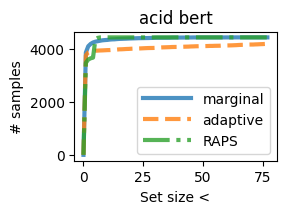

In [40]:
to_plot = [
    (y_ps_marginal, 'marginal', '-', None),
    (y_ps_adaptive, 'adaptive', '--', None),
    (y_ps_raps, 'RAPS', '-.', None),
    # (y_ps_topkmapie, 'TOPK', ':', None),
    # (y_ps_top_5_95, 'heuristic a', 'dashed', 'black'),
    # (y_ps_top_95,  'heuristic b', 'dotted', 'black'),
    # (y_ps_topk_5,  'heuristic c', '-.', 'black'),
]
fig, ax = plt.subplots(1, 1, figsize=plot.fig_dim_1)
for (resultset, label, style, color) in to_plot:
    if len(label) > len('heuristic') and label[:len('heuristic')] == 'heuristic':
        to_plot_result = resultset
    else:
        to_plot_result = resultset[:, :, target_index]
    ax.plot(
        np.cumsum([set_size_equals(to_plot_result, i) for i in range(78)]),
        label=label,
        linestyle=style,
        color=color,
        linewidth=3,
        alpha=.8)
    # ax.set_xscale('log')
plt.xlabel('Set size <')
plt.ylabel('# samples')
plt.title(f'{dataset} {intent_classifier}'.format(target_alpha))
plt.legend(handlelength=3.5)
plt.tight_layout()
plt.savefig(f'results/cum_set_size_{dataset}_{intent_classifier}.png', dpi=1200)

In [58]:
y_ps_which = y_ps_marginal
ambiguous_indices = np.where((y_ps_which[:, :, target_index].sum(axis=1) > max_ps_size))
ambiguous = df_test.loc[ambiguous_indices]
len(list(zip(ambiguous.index,[ labels[l] for l in ambiguous.label.tolist()], ambiguous.text.tolist())))

126

In [59]:
for a in ambiguous.index:
    alternatives = np.where(y_ps_which[a, :, target_index])[0]
    print(" & ".join([ambiguous.loc[a].text, labels[ambiguous.loc[a].label].replace("_", " "), ', '.join([labels[l].replace("_", " ") for l in alternatives])]) + " \\\\")

You did not answer my question & NO & INFO AGT NOT RESPONDING, INFO CANT SEE POLICY, INFO DO NOT CONTACT, INFO LOGIN ERROR, INFO PYMT ERROR, INFO WHY WAS POLICY CANCELLED, NO, ST GENERAL REQUEST, ST HELLO, ST HOW IS ABBY, ST IS ABBY REAL, ST THANK YOU, ST WHAT CAN ABBY DO, YES \\
This is actually more of a general question for Kari Leslie my agent if I can reach her & INFO WHO IS MY AGENT & INFO AGENT WRONG, INFO AGT NOT RESPONDING, INFO CL CLAIM FILED, INFO CL STATUS, INFO FIND AGENT, INFO LIFE QUESTION GENERAL, INFO THE GENERAL CONTACT, INFO WHO IS MY AGENT, ST GENERAL REQUEST, ST HELLO, ST WHAT CAN ABBY DO \\
I received a notice regarding the billing on my auto insurance policy Id like to see if you can help me prevent it from being cancelled & INFO PYMT NOT ONTIME & INFO ADD VEHICLE PROPERTY PAPERLESS BILLING, INFO CANCEL CONFIRM, INFO CANCEL FEE, INFO CANCEL INS POLICY, INFO PAPERLESS DOCS STOP, INFO PYMT NOT ONTIME, INFO REINSTATE INS POLICY, INFO WHY WAS POLICY CANCELLED \\
seco

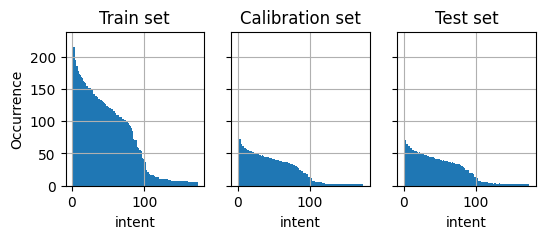

In [60]:
label_sorting_map = {i: x for x, i in enumerate(df_train.label.value_counts(sort=True).index)}
for i in range(len(labels)):
    if i not in label_sorting_map:
        label_sorting_map[i] = len(label_sorting_map)
fig, axs = plt.subplots(1,3,figsize=(plot.fig_width_in * 2, 2), sharey=True)
pd.Series(list(map(lambda x: label_sorting_map[x], df_train.label, ))).hist(bins=N_INTENTS, ax=axs[0])
pd.Series(list(map(lambda x: label_sorting_map[x], df_calibration.label, ))).hist(bins=N_INTENTS, ax=axs[1])
pd.Series(list(map(lambda x: label_sorting_map[x], df_test.label, ))).hist(bins=N_INTENTS, ax=axs[2])
titles = ['Train set', 'Calibration set', 'Test set']
[ax.set_xlabel('intent') for ax in axs]
[ax.set_title(title) for (ax, title) in zip(axs, titles)]
axs[0].set_ylabel('Occurrence')
# plt.yticks([]) 
plt.savefig(f"results/label_distribution_{dataset}.png", dpi=1200)
plt.show()

In [44]:
cq_inputs = df_test[cq_filter(y_ps_marginal[:, :, target_index], max_ps_size)].text
cq_lbls = cq_labels(y_ps_marginal[:, :, target_index], max_ps_size, labels)

cqs = []
for i, (text, lbls) in enumerate(zip(cq_inputs, cq_lbls)):
    cqs.append({
        "id": i,
        "text": text,
        "predictions": lbls,
    })

with open(f'results/clarification_questions_{dataset}_{intent_classifier}.json', 'w') as f:
    json.dump(cqs, f, indent=4)

In [70]:
pd.Series(np.cumsum([set_size_equals(y_ps_marginal[:, :, target_index], i) for i in range(N_INTENTS+1)])).to_csv(f'results/cum_{dataset}_{intent_classifier}.csv')